<a href="https://colab.research.google.com/github/jo-cho/advanced_in_financial_machine_learning/blob/master/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 Exercise

In [0]:
import numpy as np
import pandas as pd
!pip install -q mlfinlab
import mlfinlab
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 122kB 5.1MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from mlfinlab import data_structures, features, filters, labeling

## 4.1.

## (a) t1(vertical barrier touch 시간) 뽑아내기

In [0]:
#달러 바 만들기
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1000000)
#threshold = 1백만

#df 다듬기
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars.head()

Reading data in batches:
Batch number: 0
Returning bars 



,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:46:35,50.79,51.07,50.710,51.07,19844
2009-09-28 09:53:49,51.07,51.15,51.050,51.14,20324
2009-09-28 09:55:26,51.14,51.15,51.129,51.14,19622
2009-09-28 10:02:52,51.14,51.26,51.080,51.25,22319
2009-09-28 10:10:21,51.25,51.29,51.190,51.29,21519


In [0]:
len(dollar_bars)

59578

In [0]:
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')
dollar_bars.head()
len(dollar_bars)

58607

In [0]:
close = dollar_bars.close

In [0]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [0]:
DailyVol = getDailyVol(close=dollar_bars.close)
DailyVol = DailyVol.dropna()
h = DailyVol.mean()

In [0]:
tEvents = filters.cusum_filter(close,h)

In [0]:
t1 = labeling.add_vertical_barrier(tEvents,close,num_days=1)

In [0]:
t1

2009-09-28 12:33:18   2009-09-29 12:34:54
2009-09-29 09:27:39   2009-09-30 09:32:03
2009-09-29 12:00:17   2009-09-30 12:48:14
2009-09-30 09:44:47   2009-10-01 09:52:26
2009-09-30 09:56:31   2009-10-01 10:00:15
                              ...        
2019-06-18 09:39:43   2019-06-19 09:57:29
2019-06-20 09:30:00   2019-06-21 09:30:00
2019-06-20 12:20:48   2019-06-21 12:28:50
2019-06-20 15:50:44   2019-06-21 15:59:41
2019-06-25 09:42:50   2019-06-26 09:54:29
Name: date_time, Length: 3164, dtype: datetime64[ns]

### (b) number of concurrent events

In [0]:
from mlfinlab import sample_weights, sampling

In [0]:
molecule = np.array(close.index[0:1000]) #조금만 해보자

In [0]:
c = sampling.num_concurrent_events(close.index,t1,molecule)

In [0]:
c

date_time
2009-09-28 12:33:18    1
2009-09-28 13:20:29    1
2009-09-28 13:44:27    1
2009-09-28 14:05:46    1
2009-09-28 14:11:43    1
                      ..
2010-01-19 15:08:50    1
2010-01-19 15:34:01    1
2010-01-20 09:32:42    1
2010-01-20 09:57:21    1
2010-01-20 10:54:08    2
Length: 991, dtype: int64

### (c) concurrent event 수와 수익률 표준편차와의 관계

In [0]:

coEvents_std = (pd.DataFrame().assign(numCoEvents = c, std = close.pct_change().dropna().ewm(50).std()))

In [0]:
coEvents_std

,numCoEvents,std
date_time,,
2009-09-28 12:33:18,1,0.000854
2009-09-28 13:20:29,1,0.000821
2009-09-28 13:44:27,1,0.000847
2009-09-28 14:05:46,1,0.000975
2009-09-28 14:11:43,1,0.001049
...,...,...
2010-01-19 15:08:50,1,0.002140
2010-01-19 15:34:01,1,0.002138
2010-01-20 09:32:42,1,0.002358


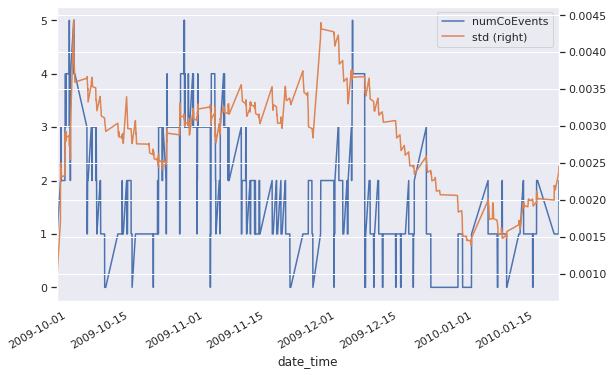

In [0]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)

### (d) plotting

In [0]:
import plotnine as pn

/usr/local/lib/python3.6/dist-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/plotnine/stats/smoothers.py:146: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"
/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)
/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:

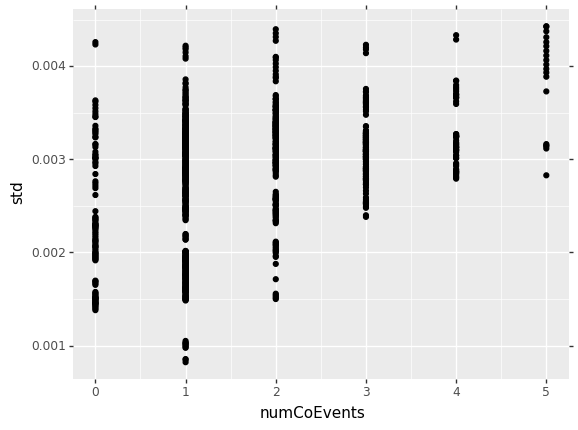

<ggplot: (8784560748159)>

In [0]:
(pn.ggplot(coEvents_std, pn.aes('numCoEvents', 'std'))
 +pn.geom_point()
 +pn.stat_smooth())

In [0]:
#overlap이 많이 됐을 때 수익률 분산이 큼


# 4.2. uniqueness 구하기, ar(1) 측정

In [0]:
pt_sl=[1,1]
target = DailyVol

In [0]:
tripple_barrier_events = labeling.get_events(close, tEvents,pt_sl,target,min_ret=0.01,num_threads=1,vertical_barrier_times=False,side_prediction= None)

/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [0]:
tW = sampling.get_av_uniqueness_from_triple_barrier(tripple_barrier_events,close,1)

In [0]:
tW

,tW
2009-10-02 09:32:42,0.812500
2009-10-02 10:34:31,0.920000
2009-10-05 12:55:39,0.900000
2009-10-06 09:31:29,0.344048
2009-10-06 11:16:28,0.311538
...,...
2019-05-15 09:30:00,0.269271
2019-05-15 10:38:24,0.262644
2019-05-16 10:01:27,0.454610
2019-05-17 09:30:00,0.333333


In [0]:
from statsmodels.tsa.ar_model import AR, ARResults

In [0]:
ar = AR(tW)
modelar = ar.fit(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [0]:
modelar.params

const    0.094741
L1.tW    0.724575
dtype: float64

In [0]:
print(modelar.pvalues,2*'\n', modelar.tvalues)
#yes

const     1.213312e-27
L1.tW    8.382844e-261
dtype: float64 

 const    10.895326
L1.tW    34.498724
dtype: float64


# 4.3 Fit a random forest to a financial dataset where $I^{−1}\sum_{i=1}^{I} \bar{u}_i \ll 1$

## (a) out-of-bag mean accuracy

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Xy = (pd.DataFrame().assign(close=close,close_lag=close.shift(1))).dropna()
## i'm not sure what this is. 저 수식을 만족시키는 건가?

y = Xy.loc[:,'close'].values
X = Xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,shuffle=False)

n_estimator = 50
rf = RandomForestRegressor(max_depth=2, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           )
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [0]:
rf.oob_score_

0.929785556021754

- OOB Score가 뭘까?

https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

https://en.wikipedia.org/wiki/Out-of-bag_error

- 왜 하라고 한 걸까?

## (b) k-fold cross-validation (no shuffle) mean accuracy

In [0]:

from sklearn.model_selection import cross_validate

n_estimator = 50
rf = RandomForestRegressor(max_depth=1, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           )

scores = cross_validate(rf, X, y, cv=5, return_estimator=True)

In [0]:
oob_scores = [est.oob_score_ for est in scores['estimator']]
np.mean(oob_scores)
#이 과정은 아직 이해가 가지 않아 베꼈다.

0.7662238411646467

## (c) comparison

Out of bag accuracy is higher than cross-validation b/c the incorrect assumption of IID draws leads to oversampling of redudant samples.

For random forests this means that the trees too similar. The random sampling also means that in-bag and out-of-bag samples will be similar inflating the oob_score_. In this example the cross-validation is less-biased.

from BlackArbsCEO

# 4.4 exponential time decay factor

In [0]:
#original one

def getTimeDecay(tW,clfLastW=1.):
# apply piecewise-linear decay to observed uniqueness (tW)
# newest observation gets weight=1, oldest observation gets weight=clfLastW
  clfW=tW.sort_index().cumsum()
  if clfLastW>=0:
    slope=(1.-clfLastW)/clfW.iloc[-1]
  else:
    slope=1./((clfLastW+1)*clfW.iloc[-1])

  const=1.-slope*clfW.iloc[-1]
  clfW=const+slope*clfW
  clfW[clfW<0]=0
  print (const,slope)
  return clfW

In [0]:
def getExTimeDecay(tW,clfLastW=1.,exponent=1):
    # apply exponential decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: 
      slope=((1.-clfLastW)/clfW.iloc[-1])**exponent
    else: 
      slope=(1./((clfLastW+1)*clfW.iloc[-1]))**exponent
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    print(const,slope)
    return clfW

In [0]:
getTimeDecay(tW,1)

tW    1.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.0
Name: 2019-06-05 09:30:00, dtype: float64


,tW
2009-10-02 09:32:42,1.0
2009-10-02 10:34:31,1.0
2009-10-05 12:55:39,1.0
2009-10-06 09:31:29,1.0
2009-10-06 11:16:28,1.0
...,...
2019-05-15 09:30:00,1.0
2019-05-15 10:38:24,1.0
2019-05-16 10:01:27,1.0
2019-05-17 09:30:00,1.0


In [0]:
getExTimeDecay(tW,1,1)

tW    1.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.0
Name: 2019-06-05 09:30:00, dtype: float64


,tW
2009-10-02 09:32:42,1.0
2009-10-02 10:34:31,1.0
2009-10-05 12:55:39,1.0
2009-10-06 09:31:29,1.0
2009-10-06 11:16:28,1.0
...,...
2019-05-15 09:30:00,1.0
2019-05-15 10:38:24,1.0
2019-05-16 10:01:27,1.0
2019-05-17 09:30:00,1.0


In [0]:
#mlfinlab함수 , exponential은 없음.

sample_weights.get_weights_by_time_decay(tripple_barrier_events,close,3,1)

2019-11-24 15:09:55.117027 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2019-11-24 15:09:55.947356 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


2009-10-02 09:32:42    1.0
2009-10-02 10:34:31    1.0
2009-10-05 12:55:39    1.0
2009-10-06 09:31:29    1.0
2009-10-06 11:16:28    1.0
                      ... 
2019-05-15 09:30:00    1.0
2019-05-15 10:38:24    1.0
2019-05-16 10:01:27    1.0
2019-05-17 09:30:00    1.0
2019-06-05 09:30:00    1.0
Name: tW, Length: 1088, dtype: float64

tW    1.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.0
Name: 2019-06-05 09:30:00, dtype: float64


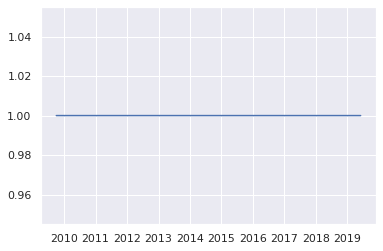

In [0]:
#c=1
plt.plot(getExTimeDecay(tW,1,1))

tW    0.6
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.001069
Name: 2019-06-05 09:30:00, dtype: float64


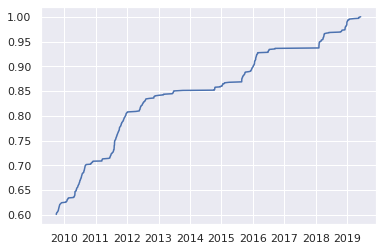

In [0]:
#c=0.6
plt.plot(getExTimeDecay(tW,0.6,1))

2019-11-24 15:21:48.761523 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2019-11-24 15:21:49.614056 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


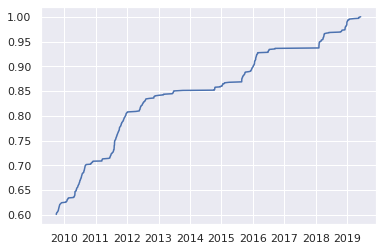

In [0]:
#mlfinlab
plt.plot(sample_weights.get_weights_by_time_decay(tripple_barrier_events,close,3,0.6))

2019-11-24 15:22:56.301029 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.


tW    0.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.002672
Name: 2019-06-05 09:30:00, dtype: float64


2019-11-24 15:22:57.141752 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


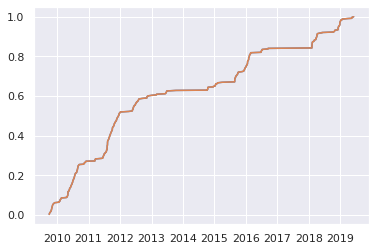

In [0]:
plt.plot(sample_weights.get_weights_by_time_decay(tripple_barrier_events,close,3,0)),
plt.plot(getExTimeDecay(tW,0,1))

2019-11-24 15:23:25.794530 100.0% num_concurrent_events done after 0.02 minutes. Remaining 0.0 minutes.
2019-11-24 15:23:26.665069 100.0% _get_average_uniqueness done after 0.01 minutes. Remaining 0.0 minutes.


tW   -0.666667
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.004454
Name: 2019-06-05 09:30:00, dtype: float64


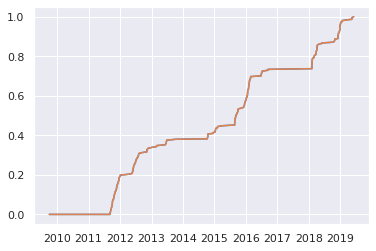

In [0]:
plt.plot(sample_weights.get_weights_by_time_decay(tripple_barrier_events,close,3,-0.4)),
plt.plot(getExTimeDecay(tW,-0.4,1))

tW   -3.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.010689
Name: 2019-06-05 09:30:00, dtype: float64
tW   -0.333333
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.003563
Name: 2019-06-05 09:30:00, dtype: float64
tW    0.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.002672
Name: 2019-06-05 09:30:00, dtype: float64
tW    0.25
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.002004
Name: 2019-06-05 09:30:00, dtype: float64
tW    0.75
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.000668
Name: 2019-06-05 09:30:00, dtype: float64
tW    1.0
Name: 2019-06-05 09:30:00, dtype: float64 tW    0.0
Name: 2019-06-05 09:30:00, dtype: float64


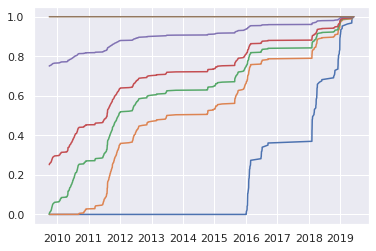

In [0]:
plt.plot(getExTimeDecay(tW,-0.75,1))
plt.plot(getExTimeDecay(tW,-0.25,1))
plt.plot(getExTimeDecay(tW,0,1))
plt.plot(getExTimeDecay(tW,0.25,1))
plt.plot(getExTimeDecay(tW,0.75,1))
plt.plot(getExTimeDecay(tW,1,1))

# 4.5 
### label 0이 2/3 1이 1/3이라고 하자.

## (a) without balancing class weight

The classifier will maximize accuracy by **over-predicting** the dominant class



## (b)
A label 1 means a true positive, and a label 0 means a false positive. By
applying balanced class weights, we are forcing the classifier to pay more
attention to the true positives, and less attention to the false positives. Why
does that make sense?

Tying the output to real-life purpose means that too many false positives result in bad trades/investments which means lost capital. From a ML perspective without balanced class weights we will maximize accuracy by simply predicting the dominant class. **We need to improve precision: TP/(TP+FP) relative to recall: TP/(TP+FN)** not just overall accuracy (TP+TN)/(TP+FP+TN+FN).

### (c)

would be more evenly distributed

# 4.6

# 4.7